# Fish sleep and bacteria growth - A review of Statistical Thinking I and II
> To begin, you'll use two data sets from Caltech researchers to rehash the key points of Statistical Thinking I and II to prepare you for the following case studies! This is the Summary of lecture "Case Studies in Statistical Thinking", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Statistics]
- image: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)

## Case Studies in Statistical Thinking
- Active bouts: a metric for wakefulness
    - Active bout: A period of time where a fish is consistently active
    - Active bout length: Number of consecutive minutes with activity
- The exponential distribution
    - Poisson process: The timing of the next event is completely independent of when the previous event happened
    - Story of Exponential distribution: The waiting time between arrivals of a Poisson process is Exponentially distributed

### EDA: Plot ECDFs of active bout length
An active bout is a stretch of time where a fish is constantly moving. Plot an ECDF of active bout length for the mutant and wild type fish for the seventh night of their lives. The data sets are in the numpy arrays `bout_lengths_wt` and `bout_lengths_mut`. The bout lengths are in units of minutes.

In [4]:
bout = pd.read_csv('./dataset/gandhi_et_al_bouts.csv', skiprows=4)
bout.head()

,genotype,bout_length,fish
0,het,12.00,1
1,het,33.00,1
2,het,0.96,1
3,het,4.98,1
4,het,1.98,1


In [13]:
bout_lengths_mut = bout[bout['genotype'] == 'mut']['bout_length'].to_numpy()
bout_lengths_wt = bout[bout['genotype'] == 'wt']['bout_length'].to_numpy()
bout_lengths_het = bout[bout['genotype'] == 'het']['bout_length'].to_numpy()

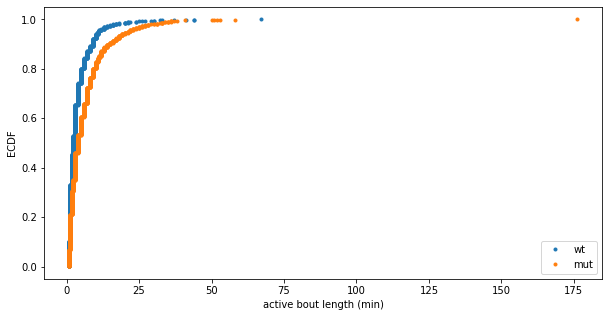

In [11]:
import dc_stat_think as dcst

# Generate x and y values for plotting ECDFs
x_wt, y_wt = dcst.ecdf(bout_lengths_wt)
x_mut, y_mut = dcst.ecdf(bout_lengths_mut)

# Plot the ECDFs
_ = plt.plot(x_wt, y_wt, marker='.', linestyle='none')
_ = plt.plot(x_mut, y_mut, marker='.', linestyle='none')

# Make a legend, label axes
_ = plt.legend(('wt', 'mut'))
_ = plt.xlabel('active bout length (min)')
_ = plt.ylabel('ECDF')

### Interpreting ECDFs and the story
Q: While a more detailed analysis of distributions is often warranted for careful analyses, you can already get a feel for the distributions and the story behind the data by eyeballing the ECDFs. Which of the following would be the most reasonable statement to make about how the active bout lengths are distributed and what kind of process might be behind exiting the active bout to rest?

A: The bout lengths appear Exponentially distributed, which implies that exiting an active bout to rest is a Poisson process; the fish have no apparent memory about when they became active.

## Bootstrap confidence intervals
- EDA is the first step
> "Exploratory data analysis can never be the whole story, but nothing else can serve as a foundation stone - as the first step". - John Tukey
- Optimal parameter value
    - Optimal parameter value: The value of the parameter of a probability distribution that best describe the data
    - Optimal parameter for the Exponential disribution: Computed from the mean of the data
- Bootstrap replicates
    - A statistic computed from a bootstrap sample
- Bootstrap confidence interval
    - If we repeated measurements over and over again, p% of the observed values would lie within the p% confidence interval

### Parameter estimation: active bout length
Compute the mean active bout length for wild type and mutant, with 95% bootstrap confidence interval. 

In [12]:
# Compute mean active bout length
mean_wt = np.mean(bout_lengths_wt)
mean_mut = np.mean(bout_lengths_mut)

# Draw bootstrap replicates
bs_reps_wt = dcst.draw_bs_reps(bout_lengths_wt, np.mean, size=10000)
bs_reps_mut = dcst.draw_bs_reps(bout_lengths_mut, np.mean, size=10000)

# Compute a 95% confidence interval
conf_int_wt = np.percentile(bs_reps_wt, [2.5, 97.5])
conf_int_mut = np.percentile(bs_reps_mut, [2.5, 97.5])

# Print the results
print("""
wt:  mean = {0:.3f} min., conf. int. = [{1:.1f}, {2:.1f}] min.
mut: mean = {3:.3f} min., conf. int. = [{4:.1f}, {5:.1f}] min.
""".format(mean_wt, *conf_int_wt, mean_mut, *conf_int_mut))


wt:  mean = 3.874 min., conf. int. = [3.6, 4.1] min.
mut: mean = 6.543 min., conf. int. = [6.1, 7.0] min.



## Permutation and bootstrap hypothesis tests
- Genotype definitions
    - Wile type: No mutations
    - Heterozygote: Mutation on one of two chromosomes
    - Mutant: Mutation on both chromosomes
- Hypothesis test
    - Assessment of how reasonable the observed data are assuming a hypothesis is true
- p-value
    - The probability of obtaining a value of your **test statistic** that is **at least as extreme as** what was observed, under the assumption the **null hypothesis** is true
    - Serves as a basis of comparison
    - Requires clear specification of:
        - **Null hypothesis** that can be simulated
        - **Test statistic** that can be calculated from observed and simulated data
        - Definition of **at least as extreme as**
- Pipeline for hypothesis testing
    - Clearly state the null hypothesis
    - Define your test statistic
    - Generate many sets of simulated data assuming the null hypothesis is true
    - Compute the test statistic for each simulated data set
    - The p-value is the fraction of your simulated data sets for which the test statistic is at least as extreme as for the real data
- Specifying the test
    - **Null hypothesis**: the active bout lengths of wild type and heterozygotic fish are identically distributed
    - **test statistic**: Difference in mean active bout length between heterozygotes and wile type
    - **At least as extreme as**: Test statistic is greater than or equal to what was observed
- Permutation test
    - For eash replicate
        - Scramble labels of data points
        - Compute test statistic
    - p-value is fraction of replicates at least as extreme as what was observed

### Permutation test: wild type versus heterozygote
Test the hypothesis that the heterozygote and wild type bout lengths are identically distributed using a permutation test.



In [16]:
# Compute the difference of means: diff_means_exp
diff_means_exp = np.mean(bout_lengths_het) - np.mean(bout_lengths_wt)

# Draw permutation replicates: perm_reps
perm_reps = dcst.draw_perm_reps(bout_lengths_het, bout_lengths_wt, 
                                dcst.diff_of_means, size=10000)

# Compute the p-value: p_val
p_val = np.sum(perm_reps >= diff_means_exp) / len(perm_reps)

# Print the result
print('p = ', p_val)

p =  0.0012


A p-value of 0.001 suggests that the observed difference in means is unlikely to occur if heterozygotic and wild type fish have active bout lengths that are identically distributed.

### Bootstrap hypothesis test
The permutation test has a pretty restrictive hypothesis, that the heterozygotic and wild type bout lengths are identically distributed. Now, use a bootstrap hypothesis test to test the hypothesis that the means are equal, making no assumptions about the distributions.



In [22]:
# Concatenate arrays: bout_lengths_concat 
bout_lengths_concat = np.concatenate([bout_lengths_wt, bout_lengths_het])

# Compute mean of all bout_lengths: mean_bout_length
mean_bout_length = np.mean(bout_lengths_concat)

# Generate shifted arrays
wt_shifted = bout_lengths_wt - np.mean(bout_lengths_wt) + mean_bout_length
het_shifted = bout_lengths_het - np.mean(bout_lengths_het) + mean_bout_length

# Compute 10,000 bootstrap replicates from shifted array
bs_reps_wt = dcst.draw_bs_reps(wt_shifted, np.mean, size=10000)
bs_reps_het = dcst.draw_bs_reps(het_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_reps = bs_reps_het - bs_reps_wt

# Compute and print p-value: p
p = np.sum(bs_reps >= diff_means_exp) / len(bs_reps)
print('p-value =', p)

p-value = 0.0003


We get a result of similar magnitude as the permutation test, though slightly smaller, probably because the heterozygote bout length distribution has a heavier tail to the right.

## Linear regressions and pairs bootstrap
- Pairs bootstrap
    - resample data in pairs
    - Compute slope and intercept from resampled data
    - Each slope and intercept is a bootstrap replicate
    - Compute confidence intervals from percentiles of bootstrap replicates

### Assessing the growth rate
To compute the growth rate, you can do a linear regression of the logarithm of the total bacterial area versus time. Compute the growth rate and get a 95% confidence interval using pairs bootstrap. The time points, in units of hours, are stored in the numpy array `t` and the bacterial area, in units of square micrometers, is stored in `bac_area`.

In [25]:
bac = pd.read_csv('./dataset/park_bacterial_growth.csv', skiprows=2)
bac.head()

,bacterial area (sq. microns),time (hr)
0,5.574735,0.00
1,5.712023,0.25
2,5.903395,0.50
3,6.194612,0.75
4,6.456708,1.00


In [26]:
bac_area = bac['bacterial area (sq. microns)'].to_numpy()
t = bac['time (hr)'].to_numpy()

In [36]:
# Compute logarithm of the bacterial area: log_bac_area
log_bac_area = np.log(bac_area)

# Compute the slope and intercept: growth_rate, log_a0
growth_rate, log_a0 = np.polyfit(t, log_bac_area, deg=1)

# Draw 10,000 pairs bootstrap replicates: growth_rate_bs_reps, log_a0_bs_reps
growth_rate_bs_reps, log_a0_bs_reps = dcst.draw_bs_pairs_linreg(t, log_bac_area, size=10000)

# Compute confidence intervals: growth_rate_conf_int
growth_rate_conf_int = np.percentile(growth_rate_bs_reps, [2.5, 97.5])

# Print the result to the screen
print("""
Growth rate: {0:.4f} sq. µm/hour
95% conf int: [{1:.4f}, {2:.4f}] sq. µm/hour
""".format(growth_rate, *growth_rate_conf_int))


Growth rate: 0.2301 sq. µm/hour
95% conf int: [0.2266, 0.2336] sq. µm/hour



Under these conditions, the bacteria add about 0.23 square micrometers worth of mass each hour. The error bar is very tight,

### Plotting the growth curve
You saw in the previous exercise that the confidence interval on the growth curve is very tight. You will explore this graphically here by plotting several bootstrap lines along with the growth curve. You will use the `plt.semilogy()` function to make the plot with the y-axis on a log scale. This means that you will need to transform your theoretical linear regression curve for plotting by exponentiating it.



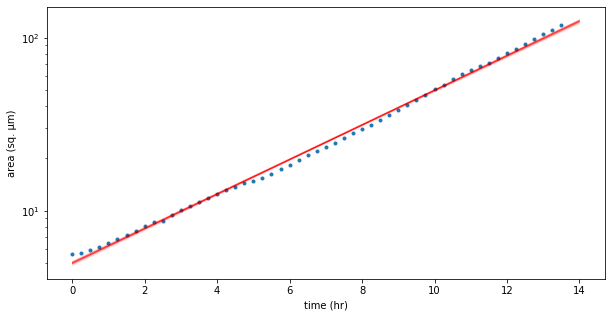

In [37]:
# Plot data points in a semilog-y plot with axis labeles
_ = plt.semilogy(t, bac_area, marker='.', linestyle='none')

# Generate x-values for the boostrap lines: t_bs
t_bs = np.array([0, 14])

# Plot the first 100 bootstrap lines
for i in range(100):
    y = np.exp(growth_rate_bs_reps[i] * t_bs + log_a0_bs_reps[i])
    _ = plt.semilogy(t_bs, y, linewidth=0.5, alpha=0.05, color='red')
    
# Label axes
_ = plt.xlabel('time (hr)')
_ = plt.ylabel('area (sq. µm)')

You can see that the bootstrap replicates do not stray much. This is due to the exquisitly exponential nature of the bacterial growth under these experimental conditions.